In [ ]:
!gdown https://drive.google.com/file/d/17DZu3jq3d_3XqsS_nSC3Wh1xPRg1fm_r/view?usp=sharing --fuzzy -O train.zip

Downloading...
From: https://drive.google.com/uc?id=17DZu3jq3d_3XqsS_nSC3Wh1xPRg1fm_r
To: /content/train.zip
100% 1.19G/1.19G [00:09<00:00, 124MB/s]


In [ ]:
!unzip -q train.zip

In [ ]:
!gdown https://drive.google.com/file/d/1DXFu96ENaNJJW1qGrb6nUjV-W7PWd4wS/view?usp=sharing --fuzzy -O test.zip

Downloading...
From: https://drive.google.com/uc?id=1DXFu96ENaNJJW1qGrb6nUjV-W7PWd4wS
To: /content/test.zip
100% 290M/290M [00:04<00:00, 61.8MB/s]


In [ ]:
!unzip -q test.zip

In [ ]:
import pandas as pd

In [ ]:
target = pd.read_csv("./train/targets.tsv", sep='\t', names=['filename', 'sex'])

In [ ]:
target.head()

,filename,sex
0,5d1f7e43366513a1d0a6ec5640c3dc24,1
1,9a701a4536a05b6610a590a9fe702ed8,1
2,cad0b8547008d1524c1a0e5fd51f9908,1
3,4bbe607e7dc95460e2cc1a6ee5f4dfa6,0
4,30fb32cba90b34af26f3f14f5d636805,0


In [ ]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13936 entries, 0 to 13935
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  13936 non-null  object
 1   sex       13936 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 217.9+ KB


In [ ]:
import librosa

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
ampl, s_rate = librosa.load("./train/0006238dc99eaf68957dfc81826d1071.wav")

In [ ]:
s_rate

22050

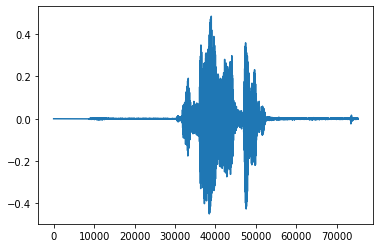

In [ ]:
plt.plot(ampl)

In [ ]:
sex = target[target['filename'] == '0006238dc99eaf68957dfc81826d1071']['sex'].values[0]

In [ ]:
sex

1

In [ ]:
from pathlib import Path

In [ ]:
TRAIN_DIR = Path("./train")
TEST_DIR = Path("./test")

train_val_files = sorted(list(TRAIN_DIR.rglob('*.wav')))
test_files = sorted(list(TEST_DIR.rglob('*.wav')))

In [ ]:
librosa.load(train_val_files[0])

(array([0.        , 0.        , 0.        , ..., 0.00051132, 0.00061684,
        0.        ], dtype=float32), 22050)

In [ ]:
train_val_files[0].name[:-4]

'0006238dc99eaf68957dfc81826d1071'

In [ ]:
import torch
import numpy as np

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from torch.utils.data import DataLoader, Dataset
from tqdm.autonotebook import trange, tqdm

In [ ]:
class VoicesDataset(Dataset):
    def __init__(self, files, mode):
      super(VoicesDataset, self).__init__()
      self.files = sorted(files)
      self.mode = mode
      self.len_ = len(self.files)

      self.features = [self.prepare_sample(path) for path in tqdm(self.files)]

      if self.mode != 'test':
        self.labels = [target[target['filename'] == path.name[:-4]]['sex'].values[0] for path in self.files]

    def __len__(self):
      return self.len_

    def prepare_sample(self, file):
      ampl, sr = librosa.load(file)
      x = self.preprocess_sample(ampl, sr)
      return x

    def __getitem__(self, index):
      #ampl, sr = librosa.load(self.files[index])
      #x = self.preprocess_sample(ampl, sr)
      x = self.features[index]
      if self.mode == 'test':
        return x
      y = self.labels[index]
      return x, y

    @staticmethod
    def spec_to_image(spec, eps=1e-6):
        mean = spec.mean()
        std = spec.std()
        spec_norm = (spec - mean) / (std + eps)
        spec_min, spec_max = spec_norm.min(), spec_norm.max()
        spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
        spec_scaled = spec_scaled.astype(np.uint8)
        return spec_scaled

    def preprocess_sample(self, amplitudes, sr=16000, max_length=150):
        spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr, n_mels=128, fmin=1, fmax=8192)[:, :max_length]
        spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
        spectrogram = np.array([self.spec_to_image(np.float32(spectrogram))]).transpose([0, 2, 1])

        return torch.tensor(spectrogram, dtype=torch.float)

In [ ]:
from sklearn.model_selection import train_test_split

train_files, val_files = train_test_split(train_val_files, test_size=0.2)

In [ ]:
modes = ['train', 'val']
files = {'train': train_files,
         'val': val_files}
datasets = {x: VoicesDataset(files[x], x) for x in modes}

  0%|          | 0/11148 [00:00<?, ?it/s]

  0%|          | 0/2788 [00:00<?, ?it/s]

In [ ]:
datasets['train'][0][0].shape

torch.Size([1, 150, 128])

In [ ]:
len(datasets['val'])

2788

In [ ]:
batch_size = 64
dataloaders = {x: DataLoader(datasets[x], batch_size=batch_size, 
                             shuffle=(x=='train'), num_workers=2) for x in modes}


In [ ]:
batch = next(iter(dataloaders['train']))

In [ ]:
batch[0].shape

torch.Size([64, 1, 150, 128])

In [ ]:
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F

In [ ]:
class Model(nn.Module):
    def __init__(self, window_sizes=[3, 5]):
        super(Model, self).__init__()

        self.convs = nn.ModuleList([
            nn.Sequential(nn.Conv2d(1, 128, [window_size, 64], padding=(window_size - 1, 0)),
                          nn.BatchNorm2d(128),
                          nn.ReLU(),
                          nn.Conv2d(128, 128, [window_size, 65], padding=(window_size - 1, 0)),
                          nn.ReLU())
            for window_size in window_sizes
        ])

        self.fc = nn.Linear(128 * len(window_sizes), 1)

    def forward(self, x):
        # Apply a convolution + max pool layer for each window size
        #x = torch.unsqueeze(x, 1)  # [B, C, T, E] Add a channel dim.
        xs = []
        for conv in self.convs:
            x2 = conv(x)  # [B, F, T, 1]
            #print(x2.shape)
            x2 = torch.squeeze(x2, -1)  # [B, F, T]
            x2 = F.max_pool1d(x2, x2.size(2))  # [B, F, 1]
            #print(x2.shape)
            xs.append(x2)
        x = torch.cat(xs, 2)  # [B, F, window]

        # FC
        x = x.view(x.size(0), -1)  # [B, F * window]
        logits = self.fc(x)  # [B, class]
        probs = torch.sigmoid(logits).view(-1)
        return probs

    def loss(self, probs, targets):
        return nn.BCELoss()(probs.float(), targets.float())

In [ ]:
def amount_parametres(model: nn.Module):
  return sum([param.numel() for param in model.parameters() if param.requires_grad])

In [ ]:
def train_model(model, loss_fn, optim, num_epochs=5):

  best_model_wts = model.state_dict()
  best_acc = 0.0

  losses = {x: [] for x in modes}

  pbar = trange(num_epochs, desc='Epoch:')

  for epoch in pbar:
    #print(f"Epoch: {epoch}")
    for phase in modes:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_correct = 0

      for inp, labels in tqdm(dataloaders[phase], leave=False,
                              desc=f'{phase} iter: '):
        inp = inp.to(device)
        labels = labels.type(torch.float32).to(device)

        if phase == 'train':
          optim.zero_grad()

        if phase == 'val':
          with torch.no_grad():
            outp = model(inp)
        else:
          outp = model(inp)
        
        preds = torch.tensor([1. if tmp > 0.5 else 0 for tmp in outp], device=device)
        loss = loss_fn(outp, labels)

        if phase == 'train':
          loss.backward()
          optim.step()

        running_loss += loss.item()
        running_correct += int(torch.sum(preds == labels.data))

      epoch_loss = running_loss / len(datasets[phase])
      epoch_acc = running_correct / len(datasets[phase])

      losses[phase].append(epoch_loss)

      pbar.set_description('%5s Loss: %.3f Acc: %.3f' % (phase, epoch_loss, epoch_acc))
      #print('%5s Loss: %.3f Acc: %.3f' % (phase, epoch_loss, epoch_acc))

      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = model.state_dict()
  print('Best val Acc: %0.4f' % (best_acc))
  model.load_state_dict(best_model_wts)
  return model, losses

In [ ]:
device

'cuda'

In [ ]:
model = Model().to(device)

loss_fn = nn.BCELoss()
optimizer = Adam(model.parameters(), betas=(0.9, 0.999), lr=3e-4)

In [ ]:
amount_parametres(model)

8586497

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model, losses = train_model(model, loss_fn, optimizer, 5)

Epoch::   0%|          | 0/5 [00:00<?, ?it/s]

train iter:   0%|          | 0/175 [00:00<?, ?it/s]

val iter:   0%|          | 0/44 [00:00<?, ?it/s]

train iter:   0%|          | 0/175 [00:00<?, ?it/s]

val iter:   0%|          | 0/44 [00:00<?, ?it/s]

train iter:   0%|          | 0/175 [00:00<?, ?it/s]

val iter:   0%|          | 0/44 [00:00<?, ?it/s]

train iter:   0%|          | 0/175 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
torch.save(model.state_dict(), "model_audio_1.pth")

In [ ]:
model.load_state_dict(torch.load("model_audio.pth"))

<All keys matched successfully>

In [ ]:
answer = {'file': [],
          'gender': []}

In [ ]:
model.eval()

def predict(inp):
    with torch.no_grad():
        out = model(torch.tensor(inp, dtype=torch.float).to(device))
        out = out.cpu().detach().numpy()
    #print(out.shape)
    out = 'male' if out < 0.5 else 'female'
    return out

In [ ]:
def prepare_sample(file):
    ampl, sr = librosa.load(file)
    x = preprocess_sample(ampl, sr)
    return x

def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

def preprocess_sample(amplitudes, sr=16000, max_length=150):
  spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr, n_mels=128, fmin=1, fmax=8192)[:, :max_length]
  spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
  spectrogram = np.array([spec_to_image(np.float32(spectrogram))]).transpose([0, 2, 1])

  return torch.tensor(spectrogram, dtype=torch.float)

In [ ]:
for path in tqdm(test_files):
  name = path.name[:-4]
  feat = prepare_sample(path).unsqueeze(0)
  #print(feat.shape)
  pred = predict(feat)
  answer['file'].append(name)
  answer['gender'].append(pred)

  0%|          | 0/3413 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [ ]:
answer = pd.DataFrame(answer)

In [ ]:
answer.head()

,file,gender
0,00100026dbdffcd01cde6ee9b9a9d273,female
1,0014278276a6cc05fe8c522af0a677df,male
2,0026e20266ceba9cdda2c116e89d2f3b,female
3,008b37fc832d3dfad9105961c5801c02,male
4,00b1d7d0d6fdb25050041f6e2ae2871e,male


In [ ]:
 answer.to_csv("answers.tsv", sep='\t', header=False, index=False)

In [ ]:
# Code for recording audio from the browser
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
import IPython
import uuid
from google.colab import output


class InvokeButton(object):
  def __init__(self, title, callback):
    self._title = title
    self._callback = callback

  def _repr_html_(self):
    from google.colab import output
    callback_id = 'button-' + str(uuid.uuid4())
    output.register_callback(callback_id, self._callback)

    template = """<button id="{callback_id}" style="cursor:pointer;background-color:#EEEEEE;border-color:#E0E0E0;padding:5px 15px;font-size:14px">{title}</button>
        <script>
          document.querySelector("#{callback_id}").onclick = (e) => {{
            google.colab.kernel.invokeFunction('{callback_id}', [], {{}})
            e.preventDefault();
          }};
        </script>"""
    html = template.format(title=self._title, callback_id=callback_id)
    return html

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  with open('audio.wav','wb+') as f:
    f.write(b)
  return 'audio.wav'

In [ ]:
import os

In [ ]:
def classify():
  print("Now recording for 3 seconds, say what you will...")
  record()
  os.system('ffmpeg -i audio.wav -ar 16000 -y audio.wav')
  print(f"Audio recording complete, guess it is {predict(prepare_sample('audio.wav').unsqueeze(0))}")

InvokeButton('Start recording', classify)

In [ ]:
classify()

Now recording for 3 seconds, say what you will...


<IPython.core.display.Javascript object>

Audio recording complete, guess it is male


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
